In [1]:
from model_helpers import *

import cfgrib
import xarray as xr

import pandas as pd
import numpy as np

from pyPhenology import models, utils

from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from warnings import warn
import warnings

warnings.filterwarnings('ignore')

high_cutoff_year = 2022
low_cutoff_year = 2010

This notebook handles training models from high-resolution weather data (ERA-5, every day of 2022). 

The plant observations can be found at `data/model_training_data/all_plants_formatted.csv` – these are generated by `construct_phenology_observations.py`.

**Data Filtering:**
- Northern Hemisphere only
- "Normal Growing Range" only (145 days - 314 days). 
- For tropical fruit, optionally filter out all fruits below 35 degrees N. 

Note: as far as training / testing efficiency goes, it is more efficient to train and test with monthly data. This notebook relies only on monthly data. 

In [2]:
# This cell should take ~1 minute

# Load in high-res weather data
print("loading weather data")
grib_data = cfgrib.open_datasets('../data/weather_data/monthly_weather_data.grib')

core_data = grib_data[0]

# This data is formatted by "construct_phenology_observations.py" in the same folder. 
print("Loading Plant Data")
formatted_plants = pd.read_csv("../data/model_training_data/all_plants_formatted.csv", index_col=0)

formatted_plants['rounded_lat'] = np.round(formatted_plants['latitude'], 1)
formatted_plants['rounded_lon'] = np.round(formatted_plants['lon_360'], 1)

site_x_vals = xr.DataArray(formatted_plants['rounded_lat'], dims=['site'])
site_y_vals = xr.DataArray(formatted_plants['rounded_lon'], dims=['site'])

print("filtering weather data")
full_weather_data = core_data.sel(latitude=site_x_vals, longitude=site_y_vals, method='nearest').to_dataframe().dropna().drop_duplicates()

print("formatting weather data")
formatted_weather = format_weather_data(full_weather_data)

formatted_weather['latitude'] = np.round(formatted_weather['latitude'], 1)
formatted_weather['longitude'] = np.round(formatted_weather['longitude'], 1)

print("adding site IDs to weather data")
formatted_plants['coordstring'] = formatted_plants['rounded_lat'].astype(str) + formatted_plants['rounded_lon'].astype(str)

formatted_weather['coordstring'] = formatted_weather['latitude'].astype(str) + formatted_weather['longitude'].astype(str)

formatted_plants['site_id'] = formatted_plants['coordstring'].str.replace(".", "")
formatted_weather['site_id'] = formatted_weather['coordstring'].str.replace(".", "")

## Add Site ID to the weather data

# filter out current year
print("separating weather data")
formatted_weather = formatted_weather[formatted_weather['year'] != 2023]

# Convert weather to Celsius (ERA-5 is in Kelvin, pyPhenology needs C)
print("converting to Celsius")
formatted_weather['temperature'] = formatted_weather['temperature'] - 272.15

# final formatting steps for plants
print("formatting plant data")
species_list = formatted_plants['formatted_sci_name'].unique()
formatted_plants.drop('species', axis=1, inplace=True)

# correct for missing sites
weather_sites = formatted_weather['site_id'].unique()

print("filtering plant data")

# Ignores Southern Hemisphere.
# Also, filtering for doy >= 60 gets most of the observations with weird date wrappings, and reduces errors that occur
# when the model predicts, for example, 300 as the day of ripeness, but the actual day is day 5. The calculated error
# would be 295 days, even though the "real error" is only ~70 days. 

filtered_plants = formatted_plants[(formatted_plants['site_id'].isin(weather_sites)) & 
                                   (formatted_plants['year'] != 2023) &
                                   (formatted_plants['latitude'] > 0) &
                                    (formatted_plants['doy'] >= 60)]

# This filters out to only "normal observations" – days with more than 20 observations. 
# This results in a much less error-prone model, but either one can be used. 
aggressive_filtered_plants = filtered_plants.query('doy >= 145 and doy <= 314')

# Filters out plants above 35 N – this should reduce error considerably, because tropical plants don't 
# necessarily follow the same GDD model. 
filtered_plants_non_tropical = filtered_plants.query('latitude >= 35')


Ignoring index file '../data/weather_data/monthly_weather_data.grib.923a8.idx' incompatible with GRIB file


loading weather data


Ignoring index file '../data/weather_data/monthly_weather_data.grib.923a8.idx' incompatible with GRIB file


Loading Plant Data
filtering weather data
formatting weather data
Converting GRIB to dataframe
formatting date columns
correcting leap years
rounding columns and constructing site ID
adding site IDs to weather data
separating weather data
converting to Celsius
formatting plant data
filtering plant data


In [3]:
# This took <3 minutes on my MacBook.(2.3GHz Quad-core Intel; 32GB RAM)

trained_models_non_trop, prediction_df_non_trop = train_species_models(filtered_plants_non_tropical, formatted_weather)



['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus sycomorus' 'Olea europaea' 'Olea europea' 'Olea' 'Morus rubra'
 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura' 'Morus australis'
 'Amelanchier alnifolia' 'Amelanchier arborea' 'Amelanchier canadensis'
 'Amelanchier grandiflora' 'Amelanchier laevis' 'Amelanchier utahensis'
 'Amelanchier' 'Citrus' 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus'
 'Rubus hayata' 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei'
 'Citrus aurantium' 'Citrus sinensis' 'Prunus americana'
 'Prunus domestica' 'Prunus maritima' 'Prunus nigra' 'Prunus cerasifera'
 'Prunus' 'Prunus cocomilia' 'Prunus salicina' 'Prunus subcordata'
 'Prunus mexicana' 'Eriobotrya japonica' 'Malus sieboldii' 'Malus'
 'Malus pumila' 'Malus domestica' 'Malus sylvestris' 'Malus coronaria'
 "Malus '" 'Malus sieversii' 'Malus baccata' 'Malus ioensis'
 'Malus hupehensis' 'Malus tschonoskii' 'Malus fusca' 'Malus angustifolia'
 'Rosmarinus officinalis' '

  0%|                                                                                                                                                                              | 0/91 [00:00<?, ?it/s]



 Rubus
Training Observations:  143
Testing Observations:  29
running model ThermalTime
making predictions for model ThermalTime


  1%|█▊                                                                                                                                                                    | 1/91 [00:01<02:35,  1.73s/it]

model ThermalTime got a MAE of 21.0
model ThermalTime got an RMSE of 35.85417324566883
model ThermalTime's median error is: 10.0
Ripeness Day: 183.0


 Rubus occidentalis
Training Observations:  48
Testing Observations:  10
running model ThermalTime


  2%|███▋                                                                                                                                                                  | 2/91 [00:04<03:46,  2.54s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 7.6
model ThermalTime got an RMSE of 9.777525249264253
model ThermalTime's median error is: 6.0
Ripeness Day: 183.0


 Ficus
Training Observations:  104
Testing Observations:  11
running model ThermalTime


  3%|█████▍                                                                                                                                                                | 3/91 [00:06<03:16,  2.23s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.5
model ThermalTime got an RMSE of 26.602631448787168
model ThermalTime's median error is: 17.0
Ripeness Day: 245.0


 Ficus carica
Training Observations:  33
Testing Observations:  8
running model ThermalTime


  4%|███████▎                                                                                                                                                              | 4/91 [00:10<03:52,  2.67s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 26.428571428571427
model ThermalTime got an RMSE of 39.09146783049796
model ThermalTime's median error is: 13.0
Ripeness Day: 253.57142857142858


 Ficus citrifolia
not enough training data


 Ficus sycomorus
not enough training data


 Olea europaea
Training Observations:  200
Testing Observations:  33
running model ThermalTime


  8%|████████████▊                                                                                                                                                         | 7/91 [00:11<01:41,  1.21s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 36.5
model ThermalTime got an RMSE of 36.9120576505835
model ThermalTime's median error is: 36.5
Ripeness Day: 245.0


 Olea europea
Not enough test data for Olea europea, interpolating
Training Observations:  46
Testing Observations:  19
running model ThermalTime
making predictions for model ThermalTime
model ThermalTime got a MAE of 29.17543859649123
model ThermalTime got an RMSE of 36.71866329154874
model ThermalTime's median error is: 19.0
Ripeness Day: 278.2631578947368


  9%|██████████████▌                                                                                                                                                       | 8/91 [00:13<02:10,  1.57s/it]



 Olea
not enough training data


 Morus rubra
Training Observations:  68
Testing Observations:  11
running model ThermalTime


 11%|██████████████████▏                                                                                                                                                  | 10/91 [00:15<01:48,  1.34s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.181818181818183
model ThermalTime got an RMSE of 21.153121411615484
model ThermalTime's median error is: 16.0
Ripeness Day: 152.9090909090909


 Morus nigra
Training Observations:  240
Testing Observations:  64
running model ThermalTime
making predictions for model ThermalTime


 12%|███████████████████▉                                                                                                                                                 | 11/91 [00:18<02:13,  1.67s/it]

model ThermalTime got a MAE of 15.363636363636363
model ThermalTime got an RMSE of 26.41538807726904
model ThermalTime's median error is: 12.0
Ripeness Day: 176.20454545454547


 Morus
Training Observations:  340
Testing Observations:  64
running model ThermalTime
making predictions for model ThermalTime


 13%|█████████████████████▊                                                                                                                                               | 12/91 [00:20<02:15,  1.72s/it]

model ThermalTime got a MAE of 17.901960784313726
model ThermalTime got an RMSE of 27.271690414039533
model ThermalTime's median error is: 13.0
Ripeness Day: 174.1764705882353


 Morus alba
Training Observations:  108
Testing Observations:  24
running model ThermalTime


 14%|███████████████████████▌                                                                                                                                             | 13/91 [00:22<02:12,  1.70s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.0625
model ThermalTime got an RMSE of 18.75999733475461
model ThermalTime's median error is: 7.0
Ripeness Day: 175.5


 Morus macroura
not enough training data


 Morus australis
not enough training data


 Amelanchier alnifolia
Training Observations:  178
Testing Observations:  11
running model ThermalTime


 18%|█████████████████████████████                                                                                                                                        | 16/91 [00:23<01:22,  1.10s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.333333333333334
model ThermalTime got an RMSE of 21.322914122292634
model ThermalTime's median error is: 8.0
Ripeness Day: 214.0


 Amelanchier arborea
Training Observations:  71
Testing Observations:  17
running model ThermalTime


 19%|██████████████████████████████▊                                                                                                                                      | 17/91 [00:25<01:29,  1.20s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 44.2
model ThermalTime got an RMSE of 62.056425936400814
model ThermalTime's median error is: 25.0
Ripeness Day: 165.0


 Amelanchier canadensis
Training Observations:  161
Testing Observations:  10
running model ThermalTime


 20%|████████████████████████████████▋                                                                                                                                    | 18/91 [00:27<01:38,  1.34s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 33.5
model ThermalTime got an RMSE of 35.85851828134193
model ThermalTime's median error is: 37.0
Ripeness Day: 203.66666666666666


 Amelanchier grandiflora
Training Observations:  233
Testing Observations:  18
running model ThermalTime


 21%|██████████████████████████████████▍                                                                                                                                  | 19/91 [00:28<01:31,  1.27s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5
model ThermalTime got an RMSE of 18.828170383762732
model ThermalTime's median error is: 18.5
Ripeness Day: 183.0


 Amelanchier laevis
Training Observations:  61
Testing Observations:  23
running model ThermalTime


 22%|████████████████████████████████████▎                                                                                                                                | 20/91 [00:30<01:40,  1.41s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.909090909090908
model ThermalTime got an RMSE of 18.250778314661243
model ThermalTime's median error is: 14.0
Ripeness Day: 166.63636363636363


 Amelanchier utahensis
not enough training data


 Amelanchier
Training Observations:  240
Testing Observations:  76
running model ThermalTime
making predictions for model ThermalTime


 24%|███████████████████████████████████████▉                                                                                                                             | 22/91 [00:32<01:29,  1.30s/it]

model ThermalTime got a MAE of 14.5
model ThermalTime got an RMSE of 18.375255100270035
model ThermalTime's median error is: 12.0
Ripeness Day: 172.5


 Citrus
Training Observations:  125
Testing Observations:  8
running model ThermalTime


 25%|█████████████████████████████████████████▋                                                                                                                           | 23/91 [00:33<01:26,  1.28s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 87.75
model ThermalTime got an RMSE of 98.71043511199817
model ThermalTime's median error is: 82.0
Ripeness Day: 229.5


 Citrus limon
not enough training data


 Rubus idaeus
Training Observations:  42
Testing Observations:  16
running model ThermalTime


 27%|█████████████████████████████████████████████▎                                                                                                                       | 25/91 [00:34<01:08,  1.03s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.25
model ThermalTime got an RMSE of 52.24940191045253
model ThermalTime's median error is: 26.5
Ripeness Day: 217.875


 Rubus ellipticus
not enough training data


 Rubus hayata
not enough training data


 Rubus odoratus
not enough training data


 Rubus phoenicolasius
Training Observations:  39
Testing Observations:  5
running model ThermalTime


 32%|████████████████████████████████████████████████████▌                                                                                                                | 29/91 [00:37<00:46,  1.33it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.0
model ThermalTime got an RMSE of 26.007691170113507
model ThermalTime's median error is: 10.0
Ripeness Day: 195.4


 Rubus rolfei
not enough training data


 Citrus aurantium
not enough training data


 Citrus sinensis
not enough training data


 Prunus americana
Training Observations:  164
Testing Observations:  45
running model ThermalTime


 36%|███████████████████████████████████████████████████████████▊                                                                                                         | 33/91 [00:38<00:36,  1.58it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 53.714285714285715
model ThermalTime got an RMSE of 72.90502628175136
model ThermalTime's median error is: 37.0
Ripeness Day: 209.57142857142858


 Prunus domestica
Training Observations:  764
Testing Observations:  19
running model ThermalTime


 37%|█████████████████████████████████████████████████████████████▋                                                                                                       | 34/91 [00:42<00:55,  1.02it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5625
model ThermalTime got an RMSE of 24.79541288222481
model ThermalTime's median error is: 15.0
Ripeness Day: 245.0


 Prunus maritima
not enough training data


 Prunus nigra
not enough training data


 Prunus cerasifera
Training Observations:  64
Testing Observations:  14
running model ThermalTime


 41%|███████████████████████████████████████████████████████████████████                                                                                                  | 37/91 [00:43<00:44,  1.22it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.666666666666666
model ThermalTime got an RMSE of 17.149667959208745
model ThermalTime's median error is: 12.0
Ripeness Day: 217.44444444444446


 Prunus
Training Observations:  343
Testing Observations:  39
running model ThermalTime
making predictions for model ThermalTime


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                | 38/91 [00:45<00:50,  1.06it/s]

model ThermalTime got a MAE of 31.25
model ThermalTime got an RMSE of 40.90334134680605
model ThermalTime's median error is: 24.5
Ripeness Day: 202.375


 Prunus cocomilia
not enough training data


 Prunus salicina
not enough training data


 Prunus subcordata
not enough training data


 Prunus mexicana
not enough training data


 Eriobotrya japonica
Training Observations:  73
Testing Observations:  3
running model ThermalTime


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                       | 43/91 [00:47<00:33,  1.45it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 24.666666666666668
model ThermalTime got an RMSE of 30.077677215281547
model ThermalTime's median error is: 13.0
Ripeness Day: 132.33333333333334


 Malus sieboldii
Training Observations:  132
Testing Observations:  10
running model ThermalTime


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 44/91 [00:49<00:41,  1.13it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 94.5
model ThermalTime got an RMSE of 110.10222522728594
model ThermalTime's median error is: 94.5
Ripeness Day: 275.0


 Malus
Training Observations:  1136
Testing Observations:  233
running model ThermalTime
making predictions for model ThermalTime


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 45/91 [00:54<01:04,  1.41s/it]

model ThermalTime got a MAE of 27.656565656565657
model ThermalTime got an RMSE of 37.822285130928464
model ThermalTime's median error is: 20.0
Ripeness Day: 245.0


 Malus pumila
Training Observations:  486
Testing Observations:  34
running model ThermalTime


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 46/91 [00:56<01:13,  1.63s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.076923076923077
model ThermalTime got an RMSE of 37.29095580184805
model ThermalTime's median error is: 11.5
Ripeness Day: 245.0


 Malus domestica
Not enough test data for Malus domestica, interpolating
Training Observations:  10867
Testing Observations:  1329
running model ThermalTime
making predictions for model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 47/91 [01:47<08:37, 11.77s/it]

model ThermalTime got a MAE of 13.273954326612778
model ThermalTime got an RMSE of 18.150355459892626
model ThermalTime's median error is: 9.0
Ripeness Day: 245.06772009029345


 Malus sylvestris
Training Observations:  17
Testing Observations:  1
running model ThermalTime


 53%|███████████████████████████████████████████████████████████████████████████████████████                                                                              | 48/91 [01:49<06:47,  9.48s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 14.0
model ThermalTime's median error is: 14.0
Ripeness Day: 245.0


 Malus coronaria
not enough training data


 Malus '
not enough training data


 Malus sieversii
not enough training data


 Malus baccata
not enough training data


 Malus ioensis
not enough training data


 Malus hupehensis
not enough training data


 Malus tschonoskii
not enough training data


 Malus fusca
not enough training data


 Malus angustifolia
not enough training data


 Rosmarinus officinalis
Training Observations:  31
Testing Observations:  10
running model ThermalTime


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 58/91 [01:52<01:20,  2.43s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 80.14285714285714
model ThermalTime got an RMSE of 86.7516982131021
model ThermalTime's median error is: 90.0
Ripeness Day: 178.85714285714286


 Juglans
Training Observations:  93
Testing Observations:  4
running model ThermalTime


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 59/91 [01:54<01:17,  2.44s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.666666666666668
model ThermalTime got an RMSE of 22.759613353482084
model ThermalTime's median error is: 23.0
Ripeness Day: 275.0


 Juglans regia
Training Observations:  17
Testing Observations:  3
running model ThermalTime


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 60/91 [01:57<01:16,  2.48s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 52.0
model ThermalTime got an RMSE of 52.952809179494906
model ThermalTime's median error is: 52.0
Ripeness Day: 245.0


 Juglans cinerea
not enough training data


 Juglans hindsii
not enough training data


 Juglans major
not enough training data


 Juglans nigra
Training Observations:  170
Testing Observations:  39
running model ThermalTime


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 64/91 [01:59<00:46,  1.73s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.555555555555557
model ThermalTime got an RMSE of 32.77024395528494
model ThermalTime's median error is: 17.0
Ripeness Day: 275.0


 Prunus serotina
Training Observations:  561
Testing Observations:  14
running model ThermalTime


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 65/91 [02:02<00:46,  1.80s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 33.714285714285715
model ThermalTime got an RMSE of 42.223893032939806
model ThermalTime's median error is: 40.0
Ripeness Day: 227.28571428571428


 Prunus virginiana
Training Observations:  427
Testing Observations:  26
running model ThermalTime


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 66/91 [02:04<00:46,  1.85s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.636363636363637
model ThermalTime got an RMSE of 16.365151445012106
model ThermalTime's median error is: 9.0
Ripeness Day: 214.0


 Prunus yedoensis
Training Observations:  17
Testing Observations:  2
running model ThermalTime


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 67/91 [02:06<00:47,  1.98s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 6.0
model ThermalTime got an RMSE of 6.0
model ThermalTime's median error is: 6.0
Ripeness Day: 153.0


 Prunus ilicifolia
not enough training data


 Prunus cerasus
Training Observations:  71
Testing Observations:  11
running model ThermalTime


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 69/91 [02:09<00:37,  1.72s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 35.1
model ThermalTime got an RMSE of 46.83268089699756
model ThermalTime's median error is: 25.0
Ripeness Day: 183.0


 Prunus emarginata
Not enough test data for Prunus emarginata, interpolating
Training Observations:  71
Testing Observations:  2
running model ThermalTime


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70/91 [02:12<00:42,  2.04s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 49.57246376811594
model ThermalTime got an RMSE of 63.340032975660016
model ThermalTime's median error is: 49.57246376811594
Ripeness Day: 245.0


 Prunus pensylvanica
Training Observations:  41
Testing Observations:  6
running model ThermalTime


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 71/91 [02:15<00:43,  2.15s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.5
model ThermalTime got an RMSE of 20.554804791094465
model ThermalTime's median error is: 15.5
Ripeness Day: 214.0


 Prunus laurocerasus
Not enough test data for Prunus laurocerasus, interpolating
Training Observations:  16
Testing Observations:  1
running model ThermalTime


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 72/91 [02:16<00:36,  1.94s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 7.625
model ThermalTime got an RMSE of 7.625
model ThermalTime's median error is: 7.625
Ripeness Day: 214.0


 Prunus serrulata
not enough training data


 Prunus avium
Training Observations:  4807
Testing Observations:  20
running model ThermalTime


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 74/91 [02:25<00:51,  3.02s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.928571428571427
model ThermalTime got an RMSE of 40.30863076669455
model ThermalTime's median error is: 13.0
Ripeness Day: 176.64285714285714


 Cornus mas
Training Observations:  39
Testing Observations:  3
running model ThermalTime


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 75/91 [02:27<00:44,  2.76s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.666666666666668
model ThermalTime got an RMSE of 26.595739007091595
model ThermalTime's median error is: 32.0
Ripeness Day: 234.66666666666666


 Ehretia tinifolia
not enough training data


 Elaeagnus multiflora
not enough training data


 Prunus fruticosa
not enough training data


 Prunus maackii
not enough training data


 Prunus mahaleb
not enough training data


 Prunus padus
not enough training data


 Prunus subhirtella
not enough training data


 Prunus tomentosa
not enough training data


 Diospyros virginiana
Training Observations:  236
Testing Observations:  71
running model ThermalTime
making predictions for model ThermalTime


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 84/91 [02:30<00:06,  1.10it/s]

model ThermalTime got a MAE of 19.612903225806452
model ThermalTime got an RMSE of 25.931672003618004
model ThermalTime's median error is: 15.0
Ripeness Day: 276.0


 Diospyros
Training Observations:  43
Testing Observations:  5
running model ThermalTime


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 85/91 [02:32<00:06,  1.12s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.0
model ThermalTime got an RMSE of 35.04996433664377
model ThermalTime's median error is: 36.0
Ripeness Day: 306.0


 Diospyros kaki
Training Observations:  25
Testing Observations:  5
running model ThermalTime


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 86/91 [02:35<00:06,  1.30s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 24.0
model ThermalTime got an RMSE of 31.567388235329194
model ThermalTime's median error is: 17.5
Ripeness Day: 313.5


 Pyrus communis
Training Observations:  4104
Testing Observations:  14
running model ThermalTime


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 87/91 [02:44<00:09,  2.48s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.428571428571427
model ThermalTime got an RMSE of 26.58678511699267
model ThermalTime's median error is: 19.0
Ripeness Day: 245.0


 Pyrus
Training Observations:  124
Testing Observations:  13
running model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 88/91 [02:46<00:07,  2.47s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.153846153846153
model ThermalTime got an RMSE of 25.97335913229909
model ThermalTime's median error is: 12.0
Ripeness Day: 245.0


 Pyrus amygdaliformis
not enough training data


 Pyrus pyraster
not enough training data


 Pyrus pyrifolia
Training Observations:  19
Testing Observations:  1
running model ThermalTime


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [02:48<00:00,  1.86s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.0
model ThermalTime got an RMSE of 31.0
model ThermalTime's median error is: 31.0
Ripeness Day: 275.0


In [5]:
prediction_df_non_trop

,site_id,formatted_sci_name,prediction,doy,ripeness_day,abs_error
0,4202683,Rubus,183,183.0,183,0.0
1,4312824,Rubus,183,181.0,183,2.0
2,3522702,Rubus,183,190.0,183,7.0
3,4302743,Rubus,183,193.0,183,10.0
4,3742808,Rubus,183,165.0,183,18.0
...,...,...,...,...,...,...
9,4932369,Pyrus,245,257.0,245,12.0
10,4232769,Pyrus,245,193.0,245,52.0
11,4152782,Pyrus,245,224.0,245,21.0
12,4302888,Pyrus,245,273.0,245,28.0


In [9]:
# This took <3 minutes on my MacBook. (2.3GHz Quad-core Intel; 32GB RAM)

trained_models, prediction_df = train_species_models(aggressive_filtered_plants, formatted_weather)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus sycomorus' 'Olea europaea' 'Olea europea' 'Olea' 'Morus rubra'
 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura' 'Morus australis'
 'Amelanchier alnifolia' 'Amelanchier arborea' 'Amelanchier canadensis'
 'Amelanchier grandiflora' 'Amelanchier laevis' 'Amelanchier utahensis'
 'Amelanchier' 'Citrus' 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus'
 'Rubus hayata' 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei'
 'Citrus aurantium' 'Citrus sinensis' 'Prunus americana'
 'Prunus domestica' 'Prunus maritima' 'Prunus nigra' 'Prunus cerasifera'
 'Prunus' 'Prunus angustifolia' 'Prunus cocomilia' 'Prunus salicina'
 'Prunus subcordata' 'Prunus mexicana' 'Prunus rivularis'
 'Eriobotrya japonica' 'Malus sieboldii' 'Malus' 'Malus pumila'
 'Malus domestica' 'Malus sylvestris' 'Malus coronaria' "Malus '"
 'Malus sieversii' 'Malus baccata' 'Malus ioensis' 'Malus hupehensis'
 'Malus tschonoskii' 'Malus fusca' 'Malus

  0%|                                                                                                                                                                              | 0/93 [00:00<?, ?it/s]



 Rubus
Training Observations:  142
Testing Observations:  29
running model ThermalTime


  1%|█▊                                                                                                                                                                    | 1/93 [00:01<02:32,  1.66s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.52173913043478
model ThermalTime got an RMSE of 40.85126787452896
model ThermalTime's median error is: 10.0
Ripeness Day: 183.0


 Rubus occidentalis
Training Observations:  48
Testing Observations:  10
running model ThermalTime


  2%|███▌                                                                                                                                                                  | 2/93 [00:07<05:55,  3.91s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 10.6
model ThermalTime got an RMSE of 13.733171520082315
model ThermalTime's median error is: 6.0
Ripeness Day: 189.2


 Ficus
Training Observations:  112
Testing Observations:  11
running model ThermalTime


  3%|█████▎                                                                                                                                                                | 3/93 [00:08<04:27,  2.97s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.5
model ThermalTime got an RMSE of 26.602631448787168
model ThermalTime's median error is: 17.0
Ripeness Day: 245.0


 Ficus carica
Training Observations:  50
Testing Observations:  9
running model ThermalTime


  4%|███████▏                                                                                                                                                              | 4/93 [00:10<03:41,  2.49s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.625
model ThermalTime got an RMSE of 29.5613768285579
model ThermalTime's median error is: 13.0
Ripeness Day: 252.5


 Ficus citrifolia
not enough training data


 Ficus sycomorus
not enough training data


 Olea europaea
Training Observations:  117
Testing Observations:  35
running model ThermalTime


  8%|████████████▍                                                                                                                                                         | 7/93 [00:12<01:56,  1.35s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 32.2
model ThermalTime got an RMSE of 42.93949231185669
model ThermalTime's median error is: 15.0
Ripeness Day: 263.0


 Olea europea
Not enough test data for Olea europea, interpolating
Training Observations:  34
Testing Observations:  16
running model ThermalTime


  9%|██████████████▎                                                                                                                                                       | 8/93 [00:15<02:14,  1.59s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.59375
model ThermalTime got an RMSE of 29.686001424165493
model ThermalTime's median error is: 17.083333333333343
Ripeness Day: 278.875


 Olea
not enough training data


 Morus rubra
Training Observations:  63
Testing Observations:  11
running model ThermalTime


 11%|█████████████████▋                                                                                                                                                   | 10/93 [00:17<01:54,  1.38s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.545454545454547
model ThermalTime got an RMSE of 24.094510879979584
model ThermalTime's median error is: 18.0
Ripeness Day: 161.0909090909091


 Morus nigra
Training Observations:  231
Testing Observations:  59
running model ThermalTime
making predictions for model ThermalTime


 12%|███████████████████▌                                                                                                                                                 | 11/93 [00:19<02:00,  1.47s/it]

model ThermalTime got a MAE of 17.404761904761905
model ThermalTime got an RMSE of 25.14008372149563
model ThermalTime's median error is: 13.5
Ripeness Day: 183.0


 Morus
Training Observations:  327
Testing Observations:  64
running model ThermalTime
making predictions for model ThermalTime


 13%|█████████████████████▎                                                                                                                                               | 12/93 [00:21<02:11,  1.62s/it]

model ThermalTime got a MAE of 16.686274509803923
model ThermalTime got an RMSE of 23.647327088518328
model ThermalTime's median error is: 13.0
Ripeness Day: 183.0


 Morus alba
Training Observations:  107
Testing Observations:  25
running model ThermalTime


 14%|███████████████████████                                                                                                                                              | 13/93 [00:23<02:20,  1.75s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 12.941176470588236
model ThermalTime got an RMSE of 18.39437254098303
model ThermalTime's median error is: 7.0
Ripeness Day: 174.1764705882353


 Morus macroura
not enough training data


 Morus australis
not enough training data


 Amelanchier alnifolia
Training Observations:  177
Testing Observations:  11
running model ThermalTime


 17%|████████████████████████████▍                                                                                                                                        | 16/93 [00:25<01:33,  1.22s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.333333333333334
model ThermalTime got an RMSE of 21.322914122292634
model ThermalTime's median error is: 8.0
Ripeness Day: 214.0


 Amelanchier arborea
Training Observations:  69
Testing Observations:  14
running model ThermalTime


 18%|██████████████████████████████▏                                                                                                                                      | 17/93 [00:27<01:37,  1.28s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 44.2
model ThermalTime got an RMSE of 62.056425936400814
model ThermalTime's median error is: 25.0
Ripeness Day: 165.0


 Amelanchier canadensis
Training Observations:  153
Testing Observations:  10
running model ThermalTime


 19%|███████████████████████████████▉                                                                                                                                     | 18/93 [00:28<01:46,  1.41s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 33.5
model ThermalTime got an RMSE of 35.85851828134193
model ThermalTime's median error is: 37.0
Ripeness Day: 203.66666666666666


 Amelanchier grandiflora
Training Observations:  227
Testing Observations:  18
running model ThermalTime


 20%|█████████████████████████████████▋                                                                                                                                   | 19/93 [00:30<01:42,  1.38s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5
model ThermalTime got an RMSE of 18.828170383762732
model ThermalTime's median error is: 18.5
Ripeness Day: 183.0


 Amelanchier laevis
Training Observations:  60
Testing Observations:  22
running model ThermalTime


 22%|███████████████████████████████████▍                                                                                                                                 | 20/93 [00:32<01:59,  1.63s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.636363636363637
model ThermalTime got an RMSE of 17.172917367444906
model ThermalTime's median error is: 10.0
Ripeness Day: 169.36363636363637


 Amelanchier utahensis
not enough training data


 Amelanchier
Training Observations:  232
Testing Observations:  76
running model ThermalTime
making predictions for model ThermalTime


 24%|███████████████████████████████████████                                                                                                                              | 22/93 [00:34<01:42,  1.44s/it]

model ThermalTime got a MAE of 14.5
model ThermalTime got an RMSE of 18.375255100270035
model ThermalTime's median error is: 12.0
Ripeness Day: 172.5


 Citrus
Training Observations:  122
Testing Observations:  24
running model ThermalTime


 25%|████████████████████████████████████████▊                                                                                                                            | 23/93 [00:38<02:13,  1.91s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.57142857142857
model ThermalTime got an RMSE of 57.162675134841514
model ThermalTime's median error is: 28.0
Ripeness Day: 183.28571428571428


 Citrus limon
not enough training data


 Rubus idaeus
Training Observations:  42
Testing Observations:  16
running model ThermalTime


 27%|████████████████████████████████████████████▎                                                                                                                        | 25/93 [00:40<01:43,  1.52s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.25
model ThermalTime got an RMSE of 52.24940191045253
model ThermalTime's median error is: 26.5
Ripeness Day: 217.875


 Rubus ellipticus
not enough training data


 Rubus hayata
not enough training data


 Rubus odoratus
not enough training data


 Rubus phoenicolasius
Training Observations:  39
Testing Observations:  5
running model ThermalTime


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 29/93 [00:41<00:59,  1.08it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.0
model ThermalTime got an RMSE of 26.007691170113507
model ThermalTime's median error is: 10.0
Ripeness Day: 195.4


 Rubus rolfei
not enough training data


 Citrus aurantium
not enough training data


 Citrus sinensis
not enough training data


 Prunus americana
Training Observations:  164
Testing Observations:  42
running model ThermalTime


 35%|██████████████████████████████████████████████████████████▌                                                                                                          | 33/93 [00:45<00:54,  1.09it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 19.252705437591537
model ThermalTime's median error is: 11.5
Ripeness Day: 224.33333333333334


 Prunus domestica
Training Observations:  762
Testing Observations:  19
running model ThermalTime


 37%|████████████████████████████████████████████████████████████▎                                                                                                        | 34/93 [00:48<01:09,  1.17s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5625
model ThermalTime got an RMSE of 24.79541288222481
model ThermalTime's median error is: 15.0
Ripeness Day: 245.0


 Prunus maritima
not enough training data


 Prunus nigra
not enough training data


 Prunus cerasifera
Training Observations:  64
Testing Observations:  14
running model ThermalTime


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 37/93 [00:50<00:55,  1.02it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.666666666666666
model ThermalTime got an RMSE of 17.149667959208745
model ThermalTime's median error is: 12.0
Ripeness Day: 217.44444444444446


 Prunus
Training Observations:  331
Testing Observations:  34
running model ThermalTime


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 38/93 [00:52<01:00,  1.11s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 30.47826086956522
model ThermalTime got an RMSE of 40.514624305412184
model ThermalTime's median error is: 23.0
Ripeness Day: 203.2173913043478


 Prunus angustifolia
not enough training data


 Prunus cocomilia
not enough training data


 Prunus salicina
not enough training data


 Prunus subcordata
not enough training data


 Prunus mexicana
not enough training data


 Prunus rivularis
not enough training data


 Eriobotrya japonica
Training Observations:  35
Testing Observations:  2
running model ThermalTime


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 45/93 [00:54<00:31,  1.53it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 62.0
model ThermalTime got an RMSE of 76.02631123499285
model ThermalTime's median error is: 62.0
Ripeness Day: 168.0


 Malus sieboldii
Training Observations:  107
Testing Observations:  5
running model ThermalTime


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 46/93 [00:56<00:38,  1.21it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 38.0
model ThermalTime got an RMSE of 38.0
model ThermalTime's median error is: 38.0
Ripeness Day: 275.0


 Malus
Training Observations:  1042
Testing Observations:  202
running model ThermalTime
making predictions for model ThermalTime


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 47/93 [01:01<01:00,  1.31s/it]

model ThermalTime got a MAE of 23.98936170212766
model ThermalTime got an RMSE of 30.89704936679987
model ThermalTime's median error is: 19.5
Ripeness Day: 245.0


 Malus pumila
Training Observations:  468
Testing Observations:  32
running model ThermalTime
making predictions for model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 48/93 [01:03<01:07,  1.50s/it]

model ThermalTime got a MAE of 16.375
model ThermalTime got an RMSE of 22.809902820193397
model ThermalTime's median error is: 10.5
Ripeness Day: 245.0


 Malus domestica
Not enough test data for Malus domestica, interpolating
Training Observations:  10855
Testing Observations:  1329
running model ThermalTime
making predictions for model ThermalTime


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 49/93 [01:56<08:07, 11.07s/it]

model ThermalTime got a MAE of 13.231268112651168
model ThermalTime got an RMSE of 18.10243615179627
model ThermalTime's median error is: 9.0
Ripeness Day: 245.06772009029345


 Malus sylvestris
Training Observations:  17
Testing Observations:  1
running model ThermalTime


 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 50/93 [01:58<06:34,  9.17s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 14.0
model ThermalTime's median error is: 14.0
Ripeness Day: 245.0


 Malus coronaria
not enough training data


 Malus '
not enough training data


 Malus sieversii
not enough training data


 Malus baccata
not enough training data


 Malus ioensis
not enough training data


 Malus hupehensis
not enough training data


 Malus tschonoskii
not enough training data


 Malus fusca
not enough training data


 Malus angustifolia
not enough training data


 Rosmarinus officinalis
Training Observations:  31
Testing Observations:  9
running model ThermalTime


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 60/93 [02:00<01:19,  2.41s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 58.0
model ThermalTime got an RMSE of 61.1228271597445
model ThermalTime's median error is: 59.0
Ripeness Day: 214.0


 Juglans
Training Observations:  94
Testing Observations:  4
running model ThermalTime


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 61/93 [02:02<01:16,  2.38s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.0
model ThermalTime got an RMSE of 20.334699407662754
model ThermalTime's median error is: 16.5
Ripeness Day: 275.0


 Juglans regia
Training Observations:  15
Testing Observations:  3
running model ThermalTime


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 62/93 [02:05<01:16,  2.48s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 52.0
model ThermalTime got an RMSE of 52.952809179494906
model ThermalTime's median error is: 52.0
Ripeness Day: 245.0


 Juglans cinerea
not enough training data


 Juglans hindsii
not enough training data


 Juglans major
not enough training data


 Juglans nigra
Training Observations:  169
Testing Observations:  39
running model ThermalTime


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/93 [02:07<00:45,  1.69s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.555555555555557
model ThermalTime got an RMSE of 32.77024395528494
model ThermalTime's median error is: 17.0
Ripeness Day: 275.0


 Prunus serotina
Training Observations:  586
Testing Observations:  17
running model ThermalTime


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 67/93 [02:09<00:43,  1.67s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.0
model ThermalTime got an RMSE of 23.01207412545761
model ThermalTime's median error is: 9.0
Ripeness Day: 203.66666666666666


 Prunus virginiana
Training Observations:  416
Testing Observations:  26
running model ThermalTime


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 68/93 [02:10<00:42,  1.69s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.636363636363637
model ThermalTime got an RMSE of 16.365151445012106
model ThermalTime's median error is: 9.0
Ripeness Day: 214.0


 Prunus yedoensis
Training Observations:  13
Testing Observations:  2
running model ThermalTime


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 69/93 [02:13<00:43,  1.81s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 6.0
model ThermalTime got an RMSE of 6.0
model ThermalTime's median error is: 6.0
Ripeness Day: 153.0


 Prunus ilicifolia
Not enough test data for Prunus ilicifolia, interpolating
Training Observations:  165
Testing Observations:  5
running model ThermalTime


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 70/93 [02:14<00:38,  1.69s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.9015923566879
model ThermalTime got an RMSE of 36.051272934446054
model ThermalTime's median error is: 30.0
Ripeness Day: 245.0


 Prunus cerasus
Training Observations:  70
Testing Observations:  9
running model ThermalTime


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 71/93 [02:16<00:37,  1.70s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.666666666666668
model ThermalTime got an RMSE of 39.29517923500428
model ThermalTime's median error is: 29.0
Ripeness Day: 200.22222222222223


 Prunus emarginata
Not enough test data for Prunus emarginata, interpolating
Training Observations:  69
Testing Observations:  1
running model ThermalTime


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 72/93 [02:18<00:39,  1.89s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.855072463768124
model ThermalTime got an RMSE of 20.855072463768124
model ThermalTime's median error is: 20.855072463768124
Ripeness Day: 214.0


 Prunus pensylvanica
Training Observations:  41
Testing Observations:  6
running model ThermalTime


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 73/93 [02:21<00:42,  2.12s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.5
model ThermalTime got an RMSE of 20.554804791094465
model ThermalTime's median error is: 15.5
Ripeness Day: 214.0


 Prunus laurocerasus
Not enough test data for Prunus laurocerasus, interpolating
Training Observations:  16
Testing Observations:  1
running model ThermalTime


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 74/93 [02:22<00:35,  1.87s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 7.625
model ThermalTime got an RMSE of 7.625
model ThermalTime's median error is: 7.625
Ripeness Day: 214.0


 Prunus serrulata
not enough training data


 Prunus avium
Training Observations:  4710
Testing Observations:  19
running model ThermalTime


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 76/93 [02:31<00:48,  2.88s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.153846153846153
model ThermalTime got an RMSE of 36.603908996801884
model ThermalTime's median error is: 13.0
Ripeness Day: 176.15384615384616


 Cornus mas
Training Observations:  42
Testing Observations:  3
running model ThermalTime


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 77/93 [02:32<00:42,  2.63s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.666666666666668
model ThermalTime got an RMSE of 26.595739007091595
model ThermalTime's median error is: 32.0
Ripeness Day: 234.66666666666666


 Ehretia tinifolia
not enough training data


 Elaeagnus multiflora
not enough training data


 Prunus fruticosa
not enough training data


 Prunus maackii
not enough training data


 Prunus mahaleb
not enough training data


 Prunus padus
not enough training data


 Prunus subhirtella
not enough training data


 Prunus tomentosa
not enough training data


 Diospyros virginiana
Training Observations:  217
Testing Observations:  62
running model ThermalTime
making predictions for model ThermalTime


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 86/93 [02:35<00:05,  1.19it/s]

model ThermalTime got a MAE of 12.65625
model ThermalTime got an RMSE of 16.864348490232288
model ThermalTime's median error is: 10.0
Ripeness Day: 275.0


 Diospyros
Training Observations:  40
Testing Observations:  5
running model ThermalTime


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 87/93 [02:36<00:05,  1.07it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.4
model ThermalTime got an RMSE of 18.926172354705006
model ThermalTime's median error is: 15.0
Ripeness Day: 275.0


 Diospyros kaki
Training Observations:  11
Testing Observations:  7
running model ThermalTime


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 88/93 [02:38<00:05,  1.05s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.5
model ThermalTime got an RMSE of 29.379698205847294
model ThermalTime's median error is: 17.5
Ripeness Day: 305.8333333333333


 Pyrus communis
Training Observations:  4095
Testing Observations:  16
running model ThermalTime


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 89/93 [02:48<00:09,  2.38s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.333333333333332
model ThermalTime got an RMSE of 29.914693528246097
model ThermalTime's median error is: 19.0
Ripeness Day: 245.0


 Pyrus
Training Observations:  125
Testing Observations:  15
running model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 90/93 [02:50<00:06,  2.33s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.066666666666666
model ThermalTime got an RMSE of 32.0374780530553
model ThermalTime's median error is: 16.0
Ripeness Day: 245.0


 Pyrus amygdaliformis
not enough training data


 Pyrus pyraster
not enough training data


 Pyrus pyrifolia
Training Observations:  17
Testing Observations:  1
running model ThermalTime


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [02:52<00:00,  1.85s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.0
model ThermalTime got an RMSE of 31.0
model ThermalTime's median error is: 31.0
Ripeness Day: 275.0


# Model Scoring and Prediction Saving

In [18]:
print("Full Model:\n")
score_model(prediction_df)
print("\nNon-Tropical Model:\n")
score_model(prediction_df_non_trop)

Full Model:

Number of Species: 49
Error metrics:
MAE: 15.74
RMSE: 22.51
Median Absolute Error: 10.5
SD portion (SD = 16.1)
0.65
Month threshold:
0.84
2 * SD portion (2SD = 32.2)
0.87

Non-Tropical Model:

Number of Species: 48
Error metrics:
MAE: 16.63
RMSE: 24.87
Median Absolute Error: 10.58
SD portion (SD = 18.49)
0.69
Month threshold:
0.83
2 * SD portion (2SD = 36.98)
0.89


aggresisve predictions and non-tropical predictions are pretty comparable. 

In [36]:
# Merge coordinates with prediction df
prediction_df_with_locations = prediction_df.merge(aggressive_filtered_plants[['site_id', 'rounded_lat', 'rounded_lon']], on="site_id").rename(columns={'rounded_lat': 'latitude', 'rounded_lon':'longitude'}).drop_duplicates()
prediction_df_nontrop_with_locations = prediction_df_non_trop.merge(filtered_plants_non_tropical[['site_id', 'rounded_lat', 'rounded_lon']], on="site_id").rename(columns={'rounded_lat': 'latitude', 'rounded_lon':'longitude'}).drop_duplicates()

prediction_df_with_locations['ripeness_end'] = prediction_df_with_locations['ripeness_day'] + 30
prediction_df_nontrop_with_locations['ripeness_end'] = prediction_df_nontrop_with_locations['ripeness_day'] + 30


In [37]:
# as expected, tropical plants vastly underperform. 
score_model(prediction_df_with_locations.query('latitude < 35'))

Number of Species: 17
Error metrics:
MAE: 35.57
RMSE: 47.47
Median Absolute Error: 21.76
SD portion (SD = 31.44)
0.61
Month threshold:
0.58
2 * SD portion (2SD = 62.88)
0.79


In [21]:
prediction_df_with_locations

,site_id,formatted_sci_name,prediction,doy,ripeness_day,abs_error,latitude,longitude
0,4202683,Rubus,183,183.0,183,0.0,42.0,268.3
2,4202683,Morus,183,181.0,183,2.0,42.0,268.3
4,4312824,Rubus,183,181.0,183,2.0,43.1,282.4
46,4312824,Morus nigra,183,183.0,183,0.0,43.1,282.4
88,4312824,Morus,183,172.0,183,11.0,43.1,282.4
...,...,...,...,...,...,...,...,...
30860,3622732,Pyrus,245,284.0,245,39.0,36.2,273.2
30861,3902656,Pyrus,245,295.0,245,50.0,39.0,265.6
30863,4032859,Pyrus,245,253.0,245,8.0,40.3,285.9
30864,4932369,Pyrus,245,257.0,245,12.0,49.3,236.9


In [22]:
prediction_df_nontrop_with_locations

,site_id,formatted_sci_name,prediction,doy,ripeness_day,abs_error,latitude,longitude
0,4202683,Rubus,183,183.0,183,0.0,42.0,268.3
2,4202683,Morus,183,181.0,183,2.0,42.0,268.3
4,4312824,Rubus,183,181.0,183,2.0,43.1,282.4
53,4312824,Morus nigra,183,183.0,183,0.0,43.1,282.4
102,4312824,Morus,183,172.0,183,11.0,43.1,282.4
...,...,...,...,...,...,...,...,...
32087,3622732,Pyrus,245,284.0,245,39.0,36.2,273.2
32088,3902656,Pyrus,245,295.0,245,50.0,39.0,265.6
32090,4032859,Pyrus,245,253.0,245,8.0,40.3,285.9
32091,4932369,Pyrus,245,257.0,245,12.0,49.3,236.9


(array([240., 236., 184., 182., 154., 137.,  92.,  78.,  80.,  60.,  52.,
         55.,  41.,  50.,  47.,  30.,  34.,  31.,  24.,  16.,   9.,  12.,
         15.,   9.,   7.,   6.,   5.,  10.,   4.,   8.,   2.,   3.,   3.,
          2.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          1.,   0.,   0.,   0.,   2.,   2.,   0.,   0.,   1.,   0.,   0.,
          2.,   1.,   0.,   0.,   1.]),
 array([  0.        ,   2.18333333,   4.36666667,   6.55      ,
          8.73333333,  10.91666667,  13.1       ,  15.28333333,
         17.46666667,  19.65      ,  21.83333333,  24.01666667,
         26.2       ,  28.38333333,  30.56666667,  32.75      ,
         34.93333333,  37.11666667,  39.3       ,  41.48333333,
         43.66666667,  45.85      ,  48.03333333,  50.21666667,
         52.4       ,  54.58333333,  56.76666667,  58.95      ,
         61.13333333,  63.31666667,  65.5       ,  67.68333333,
         69.86666667,  72.05      ,  74.23333333,  76.41666667,
         78.6 

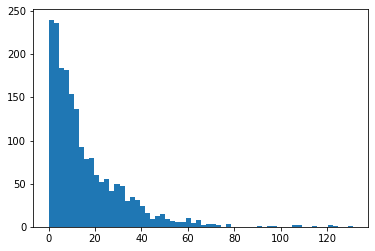

In [23]:
# histogram of the error
plt.hist(prediction_df['abs_error'], bins=60)

(array([278., 293., 235., 201., 135., 119., 104.,  71.,  70.,  47.,  64.,
         57.,  38.,  42.,  27.,  20.,  20.,  20.,  14.,   8.,   7.,   8.,
          8.,   4.,   2.,   5.,   5.,   5.,   0.,   0.,   0.,   1.,   3.,
          2.,   1.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   3.,
          0.,   0.,   1.,   0.,   2.,   1.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   1.,   0.,   1.]),
 array([  0. ,   2.8,   5.6,   8.4,  11.2,  14. ,  16.8,  19.6,  22.4,
         25.2,  28. ,  30.8,  33.6,  36.4,  39.2,  42. ,  44.8,  47.6,
         50.4,  53.2,  56. ,  58.8,  61.6,  64.4,  67.2,  70. ,  72.8,
         75.6,  78.4,  81.2,  84. ,  86.8,  89.6,  92.4,  95.2,  98. ,
        100.8, 103.6, 106.4, 109.2, 112. , 114.8, 117.6, 120.4, 123.2,
        126. , 128.8, 131.6, 134.4, 137.2, 140. , 142.8, 145.6, 148.4,
        151.2, 154. , 156.8, 159.6, 162.4, 165.2, 168. ]),
 <BarContainer object of 60 artists>)

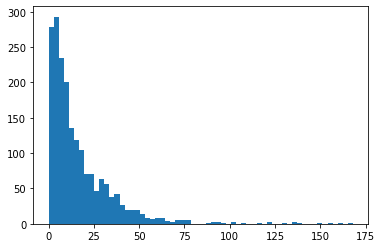

In [24]:
# histogram of the error
plt.hist(prediction_df_non_trop['abs_error'], bins=60)

In [35]:
prediction_df_with_locations.to_csv("../data/model_training_data/model_predictions/final_models/monthly_2022_predictions.csv")
prediction_df_nontrop_with_locations.to_csv("../data/model_training_data/model_predictions/final_models/monthly_2022_predictions_non_tropical.csv")

